In [1]:
%load_ext jupyter_black

import notebooks_path

notebooks_path.include_packages()
import jax.numpy as jnp
import jax.random as jr
import optax
import equinox as eqx

from vit import dataloader, util, model, train

In [2]:
batch_size = 8

In [3]:
train_dataloader = dataloader.get_train_dataloader(batch_size)
test_datalodeer = dataloader.get_test_dataloader(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
image = next(iter(test_datalodeer))

In [5]:
jax_image = jnp.array(image[0][0].numpy())
print(jax_image.shape)

(3, 32, 32)


In [6]:
patches = util.img_to_patches(jax_image, patch_size=16, flatten_channel=False)

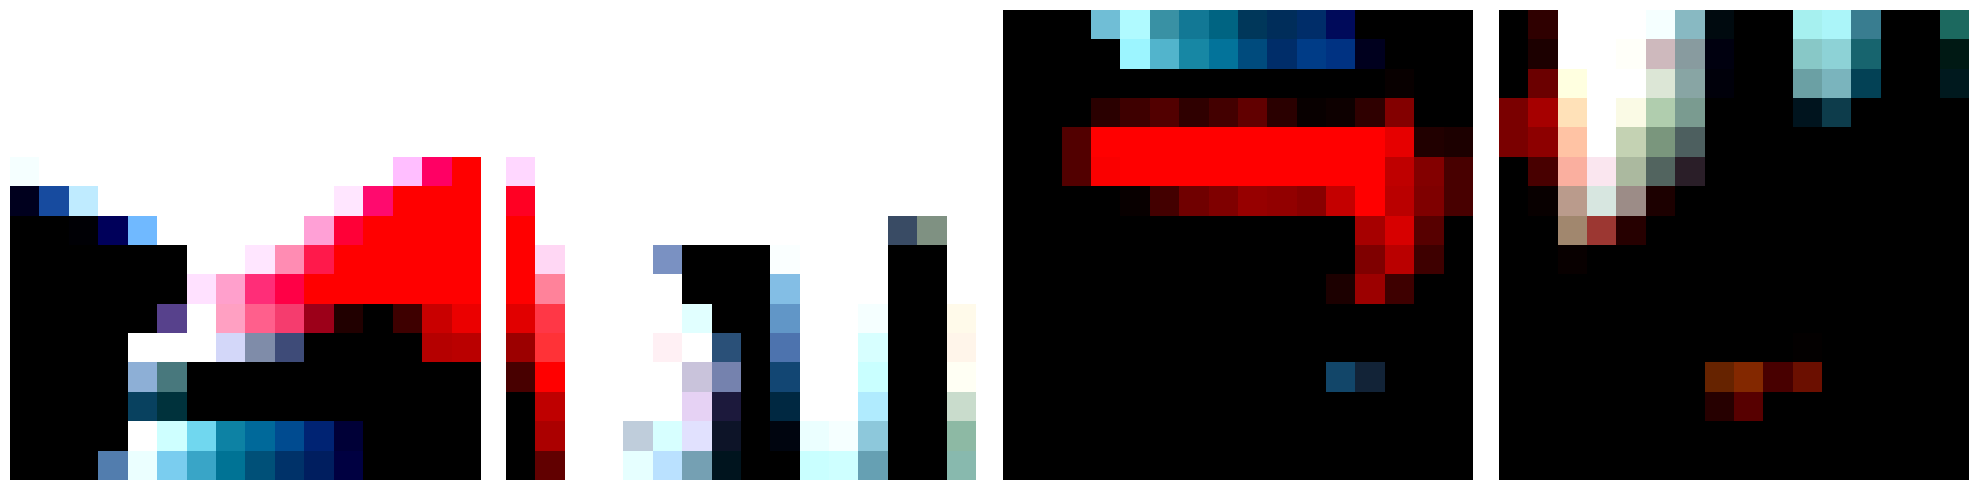

In [7]:
util.plot_patches(patches)

In [8]:
patches = util.img_to_patches(jax_image, patch_size=16, flatten_channel=False)

In [9]:
# Hyperparameters
lr = 0.0001
dropout_rate = 0.1
beta1 = 0.9
beta2 = 0.999
patch_size = 4
num_patches = 64
num_steps = 100000
image_size = (32, 32, 3)
embedding_dim = 512
hidden_dim = 256
num_heads = 8
num_layers = 6
height, width, channels = image_size
num_classes = 10

In [ ]:
key = jr.PRNGKey(2003)

model_obj = model.VisionTransformer(
    embedding_dim=embedding_dim,
    channels=channels,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    patch_size=patch_size,
    num_patches=num_patches,
    num_classes=num_classes,
    key=key,
)

optimizer = optax.adamw(
    learning_rate=lr,
    b1=beta1,
    b2=beta2,
)

state = optimizer.init(eqx.filter(model_obj, eqx.is_inexact_array))

model, _obj, state, losses = train.train(
    model_obj, optimizer, state, train_dataloader, batch_size, num_steps, key=key
)

> /teamspace/studios/this_studio/mlp-playground/playground/vit/train.py(15)compute_grads()
     13 ):
     14     import pdb; pdb.set_trace()
---> 15     logits = jax.vmap(model, in_axes=(0, None, 0))(images, True, key)
     16     loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
     17 



ipdb>  c


> /teamspace/studios/this_studio/mlp-playground/playground/vit/model.py(154)__call__()
    152         import pdb; pdb.set_trace()
    153 
--> 154         x = jnp.concatenate((self.cls_token, x), axis=0)
    155 
    156         x += self.positional_embedding[



ipdb>  c
